<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn and Salvus</h1>
</div>

In [30]:
%matplotlib inline

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [32]:
import os
import subprocess
import pprint

In [33]:
import toml
import numpy as np
import matplotlib.pyplot as plt
import h5py
import segyio

In [34]:
# Set numerical precision
DTYPE = np.float64

In [35]:
# Imports for Cervino
from cervino import *

In [36]:
# Imports for Salvus
# Workflow management
import salvus_flow.api

# Specific objects to aid in setting up simulations
from pyasdf import ASDFDataSet
from salvus_mesh.simple_config import basic_mesh
from salvus_flow.simple_config import (
    CartesianVectorSource2D, CartesianReceiver2D, RickerSTF,
    WaveformSimulation, AbsorbingBoundary)

<div class="alert alert-info">
    <h2>Domain setup</h2>
</div>

In [37]:
# Spatial discretization
d = (2.0, 2.0, 2.0)
# Number of elements
n = (500, 1, 250)

In [38]:
# Create models

# Velocity and density of first layer
vp0 = 2000
rho0 = 1000

# Velocity and density ndarrays
nx, nz = n[0], n[2]
dx, dz = d[0], d[2]
x = np.arange(nx)*dx
z = np.arange(nz)*dz

vp = np.ones((nx, nz), dtype=DTYPE)*vp0
rho = np.ones((nx, nz), dtype=DTYPE)*rho0

# Create second layer
dip = 0.1
inta = (-dip)*x + 150.0
mask = np.zeros((nx,nz), dtype=np.bool)
for i in range(nx):
    mask[i, np.rint(inta[i]/dx).astype(int):] = True
vp[mask] = 2500
rho[mask] = 1500

# Create third layer
intb = 350
vp[:,np.rint(intb/dx).astype(int):] = 2300
rho[:,np.rint(intb/dx).astype(int):] = 1300

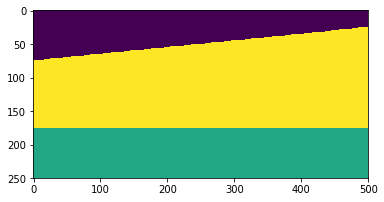

In [39]:
plt.imshow(vp.T)

In [40]:
# Create HDF5 file
f = h5py.File('acoustic2d.hdf5', 'w')
model_group = f.create_group('Models')
vp_dset = model_group.create_dataset('vp', data=vp)
rho_dset = model_group.create_dataset('rho', data=rho)
f.close()

In [41]:
# Create binary files
vp.astype('float32').tofile('simple_vp.bin')
rho.astype('float32').tofile('simple_rho.bin')

In [42]:
# f = h5py.File('acoustic2d.hdf5', 'r')
# models = f['Models'].keys()
# print(models)
# f.close()

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [43]:
domain = AcousticDomain()

In [44]:
# Set the geometry
domain.set_geometry(d=d, n=n)

In [45]:
# Set the models
domain.set_model_from_hdf5('acoustic2d.hdf5')

In [46]:
pprint.pprint(domain.get_domain_dict())

{'dimension': 3,
 'geometry': {'cell-size': (2.0, 2.0, 2.0),
              'number-of-cells': (500, 1, 250),
              'origin': (0, 0, 0)},
 'model': {'filename': 'acoustic2d.hdf5', 'format': 'hdf5'}}


<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

<div class="alert alert-danger" role="alert">
  <strong>Oh snap!</strong> max_frequency needs to be already set.
</div>

In [48]:
max_x = x[-1]
max_y = z[-1]

vs0 = vp0*0.6

max_frequency = center_frequency * 2.5

# Generate a mesh using the "simplified" meshing interface.
mesh = basic_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=vp0, vs=vs0, rho=rho0, x_max=max_x, y_max=max_y, 
    max_frequency=max_frequency).create_mesh()

# Visualize the mesh in the notebook.
mesh

<div class="alert alert-info">
    <h2>Time and frequency setup</h2>
</div>

In [47]:
# physics.wave-equation.point-source.source-time-function
center_frequency = 30.0

time_step_in_seconds = 1e-4
start_time_in_seconds = -0.2
# time_shift_in_seconds = 1.0
end_time_in_seconds = 1.0

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [49]:
# def get_time_dict():
#     r""" Return a dictionary with the time parameters.

#     The dictionary can be used to create
#     the time section of a TOML input file.
#     """

#     return {
#         "time-step-in-seconds": [time_step_in_seconds],
#         "number-of-timesteps": [number_of_timesteps],
#     }

In [50]:
get_time_dict = {
        "time-step-in-seconds": time_step_in_seconds,
        "number-of-timesteps": number_of_timesteps,
    }

In [51]:
pprint.pprint(get_time_dict)

{'number-of-timesteps': 12000, 'time-step-in-seconds': 0.0001}


<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

<div class="alert alert-info">
    <h2>Input setup</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [52]:
# Use a Ricker wavelet as source time function
stf = RickerWavelet(t, fc=center_frequency, delay=0.)

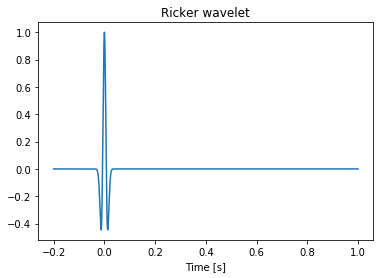

In [53]:
plt.plot(t, stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')

In [54]:
# physics.wave-equation.point-source
name = "source1"
location = (400.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

In [55]:
# Define a point source
source1 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [56]:
pprint.pprint(source1.get_source_dict())

{'location': (400.0, 0.0, 20.0),
 'source-time-function': {'center-frequency': 30.0,
                          'time-shift-in-seconds': 0.0,
                          'wavelet': 'ricker'},
 'spatial-type': 'fz',
 'spatial-weights': 1.0}


<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [57]:
fx, fy = 0.0, -1e10 # Source components (Nm)
sx, sy = 400.0, 20.0 # Source position (m)
stf = RickerSTF(center_frequency=center_frequency) # Center frequency in Hz.
source = CartesianVectorSource2D(
    name="source_0", x=sx, y=sy, fx=fx, fy=fy, 
    source_time_function=stf)

In [58]:
def get_source():
    """
    Generate the 'input' section of an input TOML file.
    """
    return {
        "wavelet": "ricker",
        "center-frequency": 25.0,
        "time-shift-in-seconds" : 1.0
    }

In [59]:
print(get_source())

{'wavelet': 'ricker', 'center-frequency': 25.0, 'time-shift-in-seconds': 1.0}


<div class="alert alert-info">
    <h2>Output setup</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [60]:
# Number of receivers
nr = nx
# Receiver z-value
rz0 = 20.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nx * d[0]

In [61]:
# Define receivers
receiver1 = ShotGather(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather', format='su')

In [62]:
pprint.pprint(receiver1.get_receiver_dict())

{'attribute': 'V01Z',
 'filename-prefix': 'vz_gather',
 'format': 'su',
 'number-of-receivers': 500,
 'receiver-increment': (2.0, 0.0, 0.0),
 'receiver-origin': (0.0, 0.0, 20.0),
 'type': 'shot_gather'}


<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [63]:
nr = 501 # Number of receivers.
ry0 = 20.0 # Receiver y-value.
rx0 = 10.0 # x-value of first receiver.
rx1 = 990.0 # x-value of last receiver.
receivers = [
    CartesianReceiver2D(
        x=x, y=ry0, station_code=f"{_i:03d}", fields=["displacement"])
        for _i, x in enumerate(np.linspace(rx0, rx1, nr))]

<div class="alert alert-info">
    <h2>Physics setup</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

<div class="alert alert-info">
    <h2>Generate TOML file</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [64]:
# Generate the complete input file.
input_file_dict = {
    "domain": domain.get_domain_dict(),
    "time": get_time_dict,
    "source": source1.get_source_dict(),
    "output": receiver1.get_receiver_dict(),
}

In [65]:
# toml.dumps(input_file_dict)

In [66]:
# Write the input file in TOML format
with open("matterhorn_input_file.toml", "w") as f:
    toml.dump(input_file_dict, f)

In [67]:
# Look at the file we've written
!cat "matterhorn_input_file.toml"

[domain]
dimension = 3

[time]
time-step-in-seconds = 0.0001
number-of-timesteps = 12000

[source]
location = [ 400.0, 0.0, 20.0,]
spatial-type = "fz"
spatial-weights = 1.0

[output]
receiver-origin = [ 0.0, 0.0, 20.0,]
receiver-increment = [ 2.0, 0.0, 0.0,]
number-of-receivers = 500
attribute = "V01Z"
filename-prefix = "vz_gather"
format = "su"
type = "shot_gather"

[domain.geometry]
origin = [ 0, 0, 0,]
number-of-cells = [ 500, 1, 250,]
cell-size = [ 2.0, 2.0, 2.0,]

[domain.model]
filename = "acoustic2d.hdf5"
format = "hdf5"

[source.source-time-function]
center-frequency = 30.0
wavelet = "ricker"
time-shift-in-seconds = 0.0


In [68]:
# input_file_dict2 = toml.load('matterhorn_input_file.toml')

In [69]:
# for k, j in input_file_dict2.items():
#     print(k)
#     print(j)

In [70]:
# Convert TOML file to the standard Matterhorn input file
mh_file = toml_to_mh('matterhorn_input_file.toml')
!cat matterhorn_input_file.sim

<grid>
origin 0 0 0
number_of_cells 500 1 250
cell_size 2.0 2.0 2.0
</grid>
<decomposition>
number_of_nodes 1 1 1
number_of_cells_per_node_x 500
number_of_cells_per_node_y 1
number_of_cells_per_node_z 250
</decomposition>
<time>
number_of_timesteps 12000
timestep_size 0.0001
</time>
<model>
type acoustic
format bin
filename_prefix ./simple
</model>
<simulation>
type acoustic_2d
order_time_operator 2
spatial_operator taylor_4
freesurface true
bc_type pml
pml_width_in_gridpoints 10
pml_power 4
pml_frequency 30.0
pml_damping_vel 3000
</simulation>
<input>
type z_source
location 400.0 0.0 20.0
wavelet ricker
central_frequency 30.0
spread trilinear
scale_factor 1.0
shift 1
</input>
<output>
type shot_gather
format su
attribute V01Z
filename_prefix vz_gather
start_timestep 0
end_timestep 11999
timestep_increment 1
receiver_origin 0.0 0.0 20.0
number_of_receivers 500
receiver_increment 2.0 0.0 0.0
</output>


<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [71]:
# Run
process = subprocess.run(['matterhorn', mh_file], stdout=subprocess.PIPE)

In [72]:
# Show output
print('Have {} bytes in stdout:\n{}'.format(len(process.stdout), process.stdout.decode('utf-8')))

Have 17302 bytes in stdout:
The OpenMP version is: 201611
Start time is Thu Apr 18 09:04:39 2019

OpenMP used. Maximum number of threads is 16

Input control parameter file is matterhorn_input_file.sim
<grid>
origin 0 0 0
number_of_cells 500 1 250
cell_size 2.0 2.0 2.0
</grid>
<decomposition>
number_of_nodes 1 1 1
number_of_cells_per_node_x 500
number_of_cells_per_node_y 1
number_of_cells_per_node_z 250
</decomposition>
<time>
number_of_timesteps 12000
timestep_size 0.0001
</time>
<model>
type acoustic
format bin
filename_prefix ./simple
</model>
<simulation>
type acoustic_2d
order_time_operator 2
spatial_operator taylor_4
freesurface true
bc_type pml
pml_width_in_gridpoints 10
pml_power 4
pml_frequency 30.0
pml_damping_vel 3000
</simulation>
<input>
type z_source
location 400.0 0.0 20.0
wavelet ricker
central_frequency 30.0
spread trilinear
scale_factor 1.0
shift 1
</input>
<output>
type shot_gather
format su
attribute V01Z
filename_prefix vz_gather
start_timestep 0
end_timestep 11999

<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [73]:
# Set up a waveform simulation object.
simulation = WaveformSimulation(
    mesh=mesh, sources=source, receivers=receivers)

# Modify the start-time, end-time, and time-step of the simulation.
simulation.physics.wave_equation.end_time_in_seconds = end_time_in_seconds
simulation.physics.wave_equation.time_step_in_seconds = time_step_in_seconds
simulation.physics.wave_equation.start_time_in_seconds = start_time_in_seconds

# Make sure that Salvus _Compute_ will accept the current options.
simulation.validate()

In [74]:
salvus_flow.api.run(
    site_name="aug04", input_file=simulation, ranks=8,
    output_folder="output", overwrite=True, get_all=True)

Job `job_1904180905_78f65` running on `aug04` with 8 rank(s).
Site information:
  * Salvus version: 0.8.2
  * Floating point size: 32


Results have been downloaded to `output`.


<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn</h3>
</div>

In [75]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

True

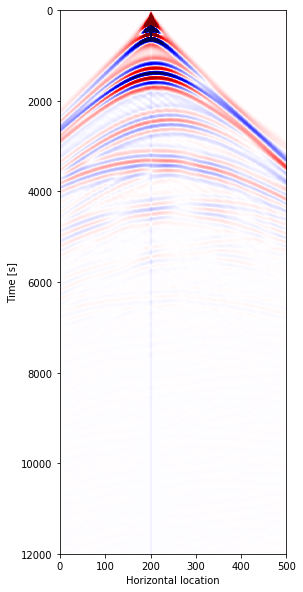

In [76]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 10)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=0.1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [77]:
sufile.close()

<div class="alert alert-info">
    <h3>Salvus</h3>
</div>

In [78]:
def make_shotgather(asdf_file):
    """
    Generate a shotgather from an ASDF file.
    """
    
#     strain_map = {"xx": 0, "yy": 1, "xy": 2}
    displacement_map = {"x": 0, "y": 1}
    with ASDFDataSet(asdf_file, mode="r") as d:
        t = d.waveforms[d.waveforms.list()[0]].displacement
        arr = np.empty((len(d.waveforms.list()), t[0].stats.npts))
        for _i, tr in enumerate(d.waveforms):
            arr[_i, :] = tr.displacement[displacement_map["y"]].data
            
    return arr

In [79]:
salvus = ASDFDataSet("output/receivers.h5", mode="r")

In [80]:
salvus_gather = make_shotgather("./output/receivers.h5").T

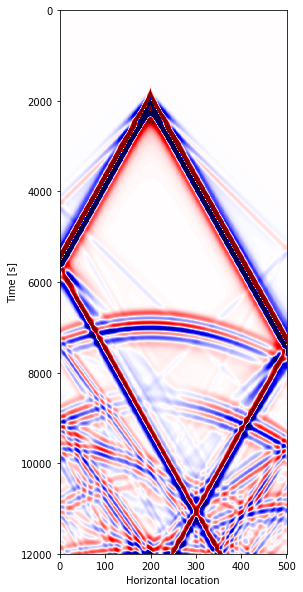

In [81]:
clip = 1e-1
vmin, vmax = -clip, clip

# Figure
figsize=(10, 10)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(salvus_gather, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=0.1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

<div class="alert alert-info">
    <h2>What's next</h2>
</div>

* This
* That